## Classification of Doodles From the Google Quick Draw dataset With Convolutional Neural Networs in Pytorch

### Imports

In [1]:
%matplotlib inline
from quickdraw import QuickDrawDataGroup
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
from torch.utils import data
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split

### Loading the data

We use the [quickdraw python API](https://github.com/martinohanlon/quickdraw_python) to load 64x64 grayscale images from the dataset by label, convert the images to tensors and create a Pytorch dataset.

In [2]:
def load_data_by_label(label_name, num_samples, im_res):
    qdg = QuickDrawDataGroup(name=label_name, recognized=True, max_drawings=num_samples)
    data = torch.stack([transforms.ToTensor()(qdg.get_drawing(i).image.resize((im_res, im_res)).convert("L")) for i in range(num_samples)])
    return data

def load_data(label_list, num_samples_per_label=1000, test_size=0.1, batch_size=64, im_res=64, num_workers=4):
    X = torch.cat([load_data_by_label(label, num_samples_per_label, im_res) for label in label_list])
    y = torch.cat([torch.full((num_samples_per_label, 1), i, dtype=torch.int64) for i in range(len(label_list))]).reshape(-1)

    X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, stratify=y)
    X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test) 

    train_iter = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size, shuffle=True, num_workers=num_workers)
    test_iter = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

im_res = 64
batch_size = 256
label_list = ["ant", "bear", "bee", "bird", "butterfly", "cat", "cow", "crab", "crocodile", "dog"]
# label_list = ["bird",  "dog"]
num_classes = len(label_list)

train_iter, test_iter = load_data(label_list=label_list, num_samples_per_label=10000, batch_size=batch_size, im_res=im_res)

loading ant drawings
load complete
loading bear drawings
load complete
loading bee drawings
load complete
loading bird drawings
load complete
loading butterfly drawings
load complete
loading cat drawings
load complete
loading cow drawings
load complete
loading crab drawings
load complete
loading crocodile drawings
load complete
loading dog drawings
load complete


We also define a utility function to plot images:

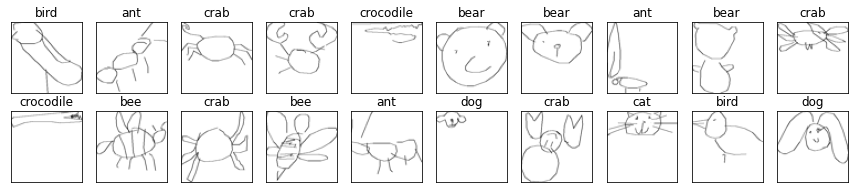

In [3]:
def show_images(imgs, num_rows, num_cols, titles=None):
    scale = 1.5
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()
 
num_imgs = 20
X, y = next(iter(train_iter))
show_images(X.reshape(batch_size, im_res, im_res)[:num_imgs, :, :], 2, 10, [label_list[int(i.item())] for i in y][:num_imgs])

### Defining the model

We start with a basic mlp on the flattened images for testing purposes.

In [4]:
# net = nn.Sequential(nn.Flatten(),
#                     nn.Linear(im_res ** 2, 256),
#                     nn.ReLU(),
#                     nn.Linear(256, num_classes))
# net = nn.Sequential(nn.Flatten(),
#                     nn.Linear(im_res ** 2, num_classes))
net = torch.nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, num_classes))

### Training

We start with a function to evaluate the model's accuracy on the test set at the end of each epoch.

In [5]:
def eval_test_acc(net, data_iter, device):
    net.eval()
    num_correct_preds = num_examples = 0.0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = y_hat.argmax(axis=1)    
        cmp = y_hat.type(y.dtype) == y
        num_correct_preds += float(cmp.type(y.dtype).sum())
        num_examples += y.numel()

    return num_correct_preds / num_examples


# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.normal_(m.weight, std=0.01)
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)


net.apply(init_weights)
device = torch.device("cuda:0")
net.to(device)

# eval_test_acc(net, test_iter, device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Training:

In [6]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.9)
loss = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(num_epochs):
    train_loss_sum = train_num_correct_preds = num_examples = 0.0
    for i, (X, y) in enumerate(train_iter):
#         net.train()
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss_sum += float(l) * y.numel()
            if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
                y_hat = y_hat.argmax(axis=1)    
            cmp = y_hat.type(y.dtype) == y
            train_num_correct_preds += float(cmp.type(y.dtype).sum())
            num_examples += y.numel()
        train_loss = train_loss_sum / num_examples
        train_acc = train_num_correct_preds / num_examples
        if (i + 1) % 10 == 0:
            print(f"epoch {epoch + 1}, iteration {i + 1}: train_loss={train_loss:.3f}, train_acc={train_acc:.3f}")

#     test_acc = eval_test_acc(net, test_iter, device)
#     print(f"epoch {epoch + 1}: test_acc={test_acc:.3f}")
print(f"Finished training: train_loss={train_loss:.3f}, train_acc={train_acc:.3f}")

epoch 1, iteration 10: train_loss=2.508, train_acc=0.096
epoch 1, iteration 20: train_loss=2.416, train_acc=0.097
epoch 1, iteration 30: train_loss=2.383, train_acc=0.094
epoch 1, iteration 40: train_loss=2.366, train_acc=0.095
epoch 1, iteration 50: train_loss=2.355, train_acc=0.099
epoch 1, iteration 60: train_loss=2.347, train_acc=0.100
epoch 1, iteration 70: train_loss=2.342, train_acc=0.101
epoch 1, iteration 80: train_loss=2.338, train_acc=0.100
epoch 1, iteration 90: train_loss=2.335, train_acc=0.099
epoch 1, iteration 100: train_loss=2.332, train_acc=0.099
epoch 1, iteration 110: train_loss=2.330, train_acc=0.099
epoch 1, iteration 120: train_loss=2.328, train_acc=0.099
epoch 1, iteration 130: train_loss=2.327, train_acc=0.100
epoch 1, iteration 140: train_loss=2.325, train_acc=0.099
epoch 1, iteration 150: train_loss=2.324, train_acc=0.099
epoch 1, iteration 160: train_loss=2.323, train_acc=0.100
epoch 1, iteration 170: train_loss=2.322, train_acc=0.101
epoch 1, iteration 180: